## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [15]:
!pip install -q kaggle

kaggle-cli 0.12.13 has requirement lxml<4.1,>=4.0.0, but you'll have lxml 4.2.1 which is incompatible.


In [20]:
!chmod 600 /home/centos/.kaggle/kaggle.json

In [33]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv.zip
!7za x -so /home/centos/.kaggle/competitions/planet-understanding-the-amazon-from-space/train-jpg.tar.7z | tar xf - -C data/
!7za x -so /home/centos/.kaggle/competitions/planet-understanding-the-amazon-from-space/test-jpg.tar.7z | tar xf - -C data/
!unzip /home/centos/.kaggle/competitions/planet-understanding-the-amazon-from-space/train_v2.csv.zip -d data/

train-jpg.tar.7z: Skipping, found more recently modified local copy (use --force to force download)
test-jpg.tar.7z: Skipping, found more recently modified local copy (use --force to force download)
train_v2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
PATH = '/home/centos/data/'

In [4]:
# Data preparation steps if you are using Crestle:

# os.makedirs('data/planet/models', exist_ok=True)
# os.makedirs('/cache/planet/tmp', exist_ok=True)

# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/test-jpg {PATH}
# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
# !ln -s /cache/planet/tmp {PATH}

In [5]:
ls {PATH}

__MACOSX/  test-jpg/  tmp/  train-jpg/  train_v2.csv


## Multi-label versus single-label classification

In [6]:
from fastai.plots import *

In [7]:
def get_1st(path): return glob(f'{path}/*.*')[0]

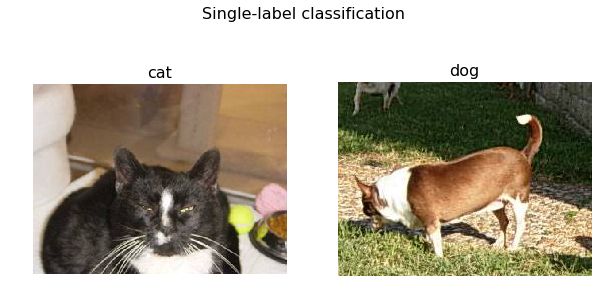

In [9]:
dc_path = "/home/centos/fastai-courses/dl1/data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

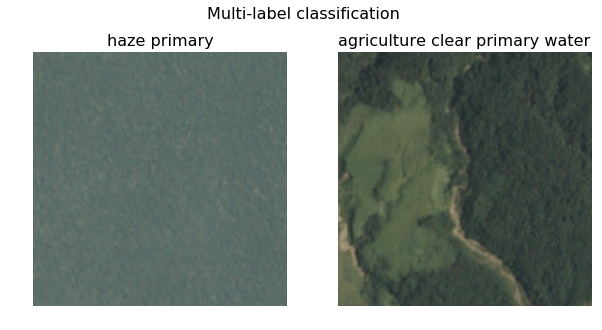

In [10]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [15]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [16]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [17]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [18]:
data = get_data(256)

In [19]:
x,y = next(iter(data.val_dl))

In [20]:
y

tensor([[ 1.,  0.,  0.,  ...,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 1.,  0.,  0.,  ...,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  1.]], device='cuda:0')

In [21]:
list(zip(data.classes, y[0]))

[('agriculture', tensor(1., device='cuda:0')),
 ('artisinal_mine', tensor(0., device='cuda:0')),
 ('bare_ground', tensor(0., device='cuda:0')),
 ('blooming', tensor(0., device='cuda:0')),
 ('blow_down', tensor(0., device='cuda:0')),
 ('clear', tensor(1., device='cuda:0')),
 ('cloudy', tensor(0., device='cuda:0')),
 ('conventional_mine', tensor(0., device='cuda:0')),
 ('cultivation', tensor(0., device='cuda:0')),
 ('habitation', tensor(0., device='cuda:0')),
 ('haze', tensor(0., device='cuda:0')),
 ('partly_cloudy', tensor(0., device='cuda:0')),
 ('primary', tensor(1., device='cuda:0')),
 ('road', tensor(0., device='cuda:0')),
 ('selective_logging', tensor(0., device='cuda:0')),
 ('slash_burn', tensor(0., device='cuda:0')),
 ('water', tensor(1., device='cuda:0'))]

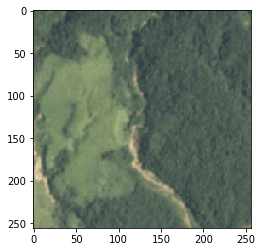

In [22]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [23]:
sz=64

In [24]:
data = get_data(sz)

In [25]:
data = data.resize(int(sz*1.3), 'tmp')

In [26]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

/home/centos/venv/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   f2                          
    0      0.215641   0.253464   0.811089  



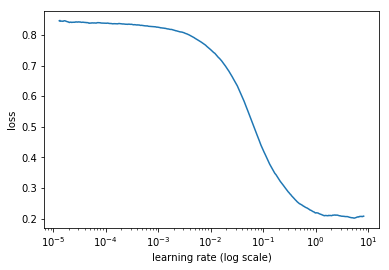

In [27]:
lrf=learn.lr_find()
learn.sched.plot()

In [28]:
lr = 0.2

In [29]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.146025   0.135333   0.878934  
    1      0.143217   0.129627   0.885245                    
    2      0.137314   0.127816   0.887786                    
    3      0.13852    0.126916   0.887731                    
    4      0.136559   0.124885   0.890971                    
    5      0.131964   0.123064   0.893206                    
    6      0.132738   0.122791   0.893186                    



[0.12279140516204404, 0.8931859848203969]

In [30]:
lrs = np.array([lr/9,lr/3,lr])

In [31]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.123633   0.110359   0.906521  
    1      0.11503    0.105993   0.909351                    
    2      0.107714   0.101905   0.914498                    
    3      0.112593   0.104614   0.912625                    
    4      0.108501   0.100203   0.915839                    
    5      0.099114   0.099033   0.91621                      
    6      0.10087    0.098128   0.917242                     



[0.09812832400801007, 0.9172418629022012]

In [32]:
learn.save(f'{sz}')

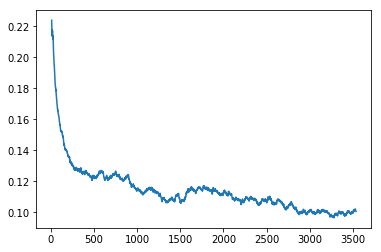

In [33]:
learn.sched.plot_loss()

In [34]:
sz=128

In [35]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.099108   0.09681    0.916384  
    1      0.09913    0.096885   0.916745                     
    2      0.098843   0.095068   0.918387                     
    3      0.09494    0.095524   0.917264                     
    4      0.096593   0.094028   0.919027                     
    5      0.096669   0.093824   0.91917                      
    6      0.094024   0.093758   0.919377                     



[0.0937584369923687, 0.9193767730210688]

In [36]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

epoch      trn_loss   val_loss   f2                           
    0      0.09508    0.08768    0.928098  
    1      0.09316    0.088765   0.927213                     
    2      0.090511   0.086439   0.92884                      
    3      0.090482   0.087657   0.926982                     
    4      0.090353   0.086626   0.928885                     
    5      0.08414    0.085128   0.928927                     
    6      0.084196   0.085271   0.928851                     



In [37]:
sz=256

In [38]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.092229   0.089633   0.92459   
    1      0.090762   0.088626   0.925452                     
    2      0.090563   0.088344   0.925758                     
    3      0.089308   0.087957   0.926799                     
    4      0.092218   0.087727   0.926173                     
    5      0.086916   0.087052   0.927641                     
    6      0.086994   0.087724   0.926342                     



[0.08772411096548872, 0.9263415252006119]

In [39]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

epoch      trn_loss   val_loss   f2                           
    0      0.086904   0.083791   0.930494  
    1      0.086427   0.084461   0.930157                     
    2      0.084231   0.082294   0.931777                     
    3      0.086042   0.084809   0.931247                     
    4      0.083493   0.083113   0.930232                     
    5      0.079589   0.082017   0.932392                     
    6      0.076026   0.081862   0.931784                     



In [40]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [41]:
f2(preds,y)

0.9308320769311862

### End